In [3]:
# import qiime2
import pandas as pd
import numpy as np
import torch as t
## Uncomment to get rid of warnings
#import warnings
#warnings.filterwarnings('ignore') 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [4]:
## DATA PATHS ##
fungi_decontaminated_path = 'data/raw/count_data_fungi_decontaminated_HMS_1986samples.tsv'
fungi_high_coverage_path = 'data/raw/count_data_fungi_high_coverage_HMS_1986samples.tsv'
fungi_WSI_intersect_path = 'data/raw/count_data_fungi_WIS_intersect_HMS_1986samples.tsv'
fungi_metadata_path = 'data/raw/metadata_fungi_HMS_1986samples.tsv'
tcga_abbrev_path = 'data/raw/tcga_abbreviations.csv'

In [5]:
## DATA READS ##
fungi_decontaminated = pd.read_csv(fungi_decontaminated_path, sep='\t', header=0, index_col='sampleid')
fungi_high_coverage = pd.read_csv(fungi_high_coverage_path, sep='\t', header=0, index_col='sampleid')
fungi_WSI_intersect = pd.read_csv(fungi_WSI_intersect_path, sep='\t', header=0, index_col='sampleid')
fungi_metadata = pd.read_csv(fungi_metadata_path, sep='\t', header=0, index_col='sampleid')
tcga_abbrev = pd.read_csv(tcga_abbrev_path, index_col='dz')

In [6]:
## DATA CLEANING/PRE-PROCESSING ##
fungi_metadata_cols = ['disease_type','sample_type'] 
fungi_metadata = fungi_metadata[fungi_metadata_cols] #grab needed columns
fungi_metadata = fungi_metadata[fungi_metadata['sample_type'] == 'Primary Tumor'] #filter only Primary Tumors

min_count = 20 #drop cancers with fewer than 20 samples
fungi_metadata = fungi_metadata[fungi_metadata['disease_type'].map(fungi_metadata['disease_type'].value_counts()) > min_count]
samples = fungi_metadata.index #relevant sampleID's after final cleaning

## DATA FOR ML ##
fungi_decontaminated = fungi_decontaminated.filter(items = samples, axis=0) #filter feature tables for relevant samples
fungi_high_coverage = fungi_high_coverage.filter(items = samples, axis=0)
fungi_WSI_intersect = fungi_WSI_intersect.filter(items = samples, axis=0)
cancer_types = pd.get_dummies(fungi_metadata['disease_type']) #one hot encode disease types


In [7]:
def abbreviate(string):
    abbr = tcga_abbrev.loc[string][0]
    return abbr

def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25, axes=None):
    mean = np.mean(values)
    stdev = np.std(values)
    confidence_interval = z * stdev / (len(values)**(1/2))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    
    axes.plot([x, x], [top, bottom], color=color)
    axes.plot([left, right], [top, top], color=color)
    axes.plot([left, right], [bottom, bottom], color=color)
    axes.plot(x, mean, '.', color=color)

    return mean, confidence_interval


def plot_baseline(proportion, x, color='#2187bb', horizontal_line_width=0.25, axes=None):
    left = x - 0.3 - horizontal_line_width / 2
    right = x + 0.3 + horizontal_line_width / 2
    
    axes.plot([left, right], [proportion, proportion], color=color)

    return


In [8]:
## BUILD MODEL ##

#TODO: define cross validation hyperparams
n_splits = 10
skf_random = 0 #DO NOT TOUCH
shuffle=True
#TODO: define model hyperparams, can automate tuning later
loss = 'exponential'
learning_rate = 0.1
n_estimators = 150
max_depth = 3
clf_random = 0 #DO NOT TOUCH

#TODO: implement model(s)
skf = StratifiedKFold(n_splits=n_splits, random_state=skf_random, shuffle=shuffle)

#clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random)
clf = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=clf_random)

In [9]:
## INITIALIZE PLOT ##
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)

y_ticks = plt.yticks(np.arange(11)/10)
x_ticks = plt.xticks(np.arange(1, len(cancer_types.columns)+1), [abbreviate(cancer) for cancer in cancer_types.columns])

plt.ylabel('Area Under Curve', fontsize='large')
plt.autoscale(enable = False, tight=False, axis = 'y')
ax[0].set_title('AUROC')
ax[1].set_title('AUPR')

Text(0.5, 1.0, 'AUPR')

In [10]:
## AUTOMATION TIME! ##
colors = ['red','blue','orange']
offsets = [-0.3, 0, 0.3]
datasets = [fungi_high_coverage, fungi_WSI_intersect, fungi_decontaminated]

for color, offset, dataset in zip(colors, offsets, datasets):
    color = color
    offset = offset
    X = dataset
    
    for i, cancer in enumerate(cancer_types.columns, start=1):
        
        y = cancer_types[cancer]
        proportion = y.mean()
        
        auroc_plt_data = np.array([])
        aupr_plt_data = np.array([])
        
        for train_index, val_index in skf.split(X, y):
            train_X, train_y = X.iloc[train_index], y.iloc[train_index]
            val_X, val_y = X.iloc[val_index], y.iloc[val_index]

            clf.fit(train_X, train_y) #re-fit model

            preds = clf.predict_proba(val_X)[:,1] #predict, probability of positive class predict

            auroc = roc_auc_score(val_y, preds) #TODO: implement separate score function to return multiple scores
            aupr = average_precision_score(val_y, preds)
            
            auroc_plt_data = np.append(auroc_plt_data, auroc)
            aupr_plt_data = np.append(aupr_plt_data, aupr)

        plot_confidence_interval(i+offset, auroc_plt_data, color=color, axes=ax[0]) #AUROC plot
        plot_confidence_interval(i+offset, aupr_plt_data, color=color, axes=ax[1]) #AUPR plot
        plot_baseline(proportion=proportion, x=i, axes=ax[1]) #AUPR baselines

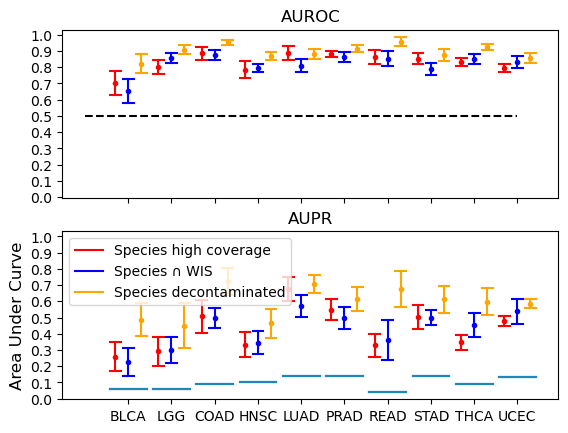

In [14]:
ax[0].hlines(0.5, xmin=0, xmax=10, linestyle ='dashed', color = 'black')
custom_lines = [Line2D([0], [0], color='red'),
                Line2D([0], [0], color='blue'),
                Line2D([0], [0], color='orange')]
plt.legend(labels=['Species high coverage','Species ∩ WIS','Species decontaminated'],
           handles=custom_lines)
fig